# Modelling epidemics evolution SIR model through a factored MDP

brief descrition about this work

## Dependencies setup


In [1]:
# Install python dependencies when needed (usually when this notebook is ran from Google Colab)
#!rm -rf ./*

#!git clone https://github.com/danielbdias/mdp-sir-modelling.git
#!mv ./mdp-sir-modelling/* ./
#!rm -rf ./mdp-sir-modelling
#!rm -rf ./sample_data
#!pip install -r requirements.txt

# enable rich graphs instead of images on notebook
import mpld3
mpld3.enable_notebook()

# code dependencies
from sir_modelling.simulation import plot_sir
from sir_modelling.enumerative_model import create_representation, simulate_policy
from mdp.algorithms.value_iteration import enumerative_finite_horizon_value_iteration

## Creating a model

Model parameters

In [2]:
approximation_threshold = 0.01

# beta (infection rate)
# assumption
# beta < 1.0 - social distancing
# beta >= 1.0 - no social distancing
betas = [0.5, 1.0, 2.5, 4]

# recovery rate (1 person each 4 days)
gamma = 1.0 / 4.0

horizon = 30
discount_factor = 0.9

initial_state = "s_99_i_01_r_00"

Creating MDP representation

In [3]:
mdp = create_representation(approximation_threshold, gamma, betas)

print(f"states: {len(mdp.states)}, {mdp.states[0:5]}")
print(f"actions: {mdp.actions}")

first_action = mdp.actions[0]

print(f"reward: {mdp.reward_matrix(first_action)[0, 0]}")

print(f"transition: {mdp.transition_matrix(first_action)[0, 0]}")
print(f"transition: {mdp.transition_matrix(first_action)[0, 1]}")

states: 5151, ['s_00_i_00_r_100', 's_00_i_01_r_99', 's_00_i_02_r_98', 's_00_i_03_r_97', 's_00_i_04_r_96']
actions: [0.5, 1.0, 2.5, 4]
reward: 500.0
transition: 1.0
transition: 0.0


Running Value Iteration on model

In [4]:
policy, value_function, statistics = enumerative_finite_horizon_value_iteration(mdp, discount_factor, horizon)

print(f"statistics: {statistics}")
print(f"max value: {max(value_function)}")
print(f"policy for first state: {policy[mdp.states[0]]}")
print(f"policy for initial state: {policy[initial_state]}")
print(f"min beta in policy: {min(policy.values())}")
print(f"max beta in policy: {max(policy.values())}")

statistics: {'iterations': 30, 'bellman_backups_done': 154530}
max value: [9576.08841725]
policy for first state: 0.5
policy for initial state: 0.5
min beta in policy: 0.5
max beta in policy: 2.5


Simulate model using MDP

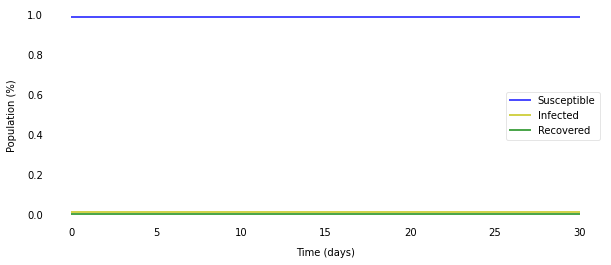

In [5]:
S, I, R = simulate_policy(policy, initial_state, mdp, horizon, approximation_threshold)

t = list(range(horizon + 1))
plot_sir(t, S, I, R)